In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from keras.datasets import mnist
import matplotlib.pyplot as plt
import torch.nn.init as init
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from functools import partial
from os.path  import join
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

E0000 00:00:1741012393.677380      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def seed_everything(seed=42):
  random.seed(seed)  # Python's random module
  torch.manual_seed(seed)  # PyTorch (CPU)
  torch.cuda.manual_seed(seed)  # PyTorch (GPU)
  torch.cuda.manual_seed_all(seed)  # Multi-GPU
  torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
  torch.backends.cudnn.benchmark = False  # Disables auto-optimization for speed (useful for reproducibility)

In [4]:
seed_everything(34)
#torch.random.get_rng_state()

# Load MNIST Dataset

In [7]:
# Functions to read Image & Label from given file path
def read_idx_images(file_path):
    """ Reads an IDX image file and returns a tensor of shape (N, 28, 28) """
    with open(file_path, 'rb') as f:
        f.read(4)  # Skip magic number
        num_images = int.from_bytes(f.read(4), 'big')
        rows = int.from_bytes(f.read(4), 'big')
        cols = int.from_bytes(f.read(4), 'big')
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols)
        return torch.tensor(data, dtype=torch.float32)  # Convert to float

def read_idx_labels(file_path):
    """ Reads an IDX label file and returns a tensor of shape (N,) """
    with open(file_path, 'rb') as f:
        f.read(4)  # Skip magic number
        num_labels = int.from_bytes(f.read(4), 'big')
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return torch.tensor(data, dtype=torch.long)  # Convert to long tensor

In [9]:
#(X_train, y_train), (X_test, y_test) = mnist.load_data()
train_images_path = "/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte"
train_labels_path = "/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte"
test_images_path = "/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte"
test_labels_path = "/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte"

# Load images and labels
X_train = read_idx_images(train_images_path)
y_train = read_idx_labels(train_labels_path)
X_test = read_idx_images(test_images_path)
y_test = read_idx_labels(test_labels_path)

In [10]:
X_train = torch.tensor(X_train).to(torch.float).unsqueeze(1).to(device)
y_train = torch.tensor(y_train,dtype=torch.int64).to(device)
X_test = torch.tensor(X_test).to(torch.float).unsqueeze(1).to(device)
y_test = torch.tensor(y_test,dtype=torch.int64).to(device)

/tmp/ipykernel_10/3783205199.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).to(torch.float).unsqueeze(1).to(device)
/tmp/ipykernel_10/3783205199.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train,dtype=torch.int64).to(device)
/tmp/ipykernel_10/3783205199.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).to(torch.float).unsqueeze(1).to(device)
/tmp/ipykernel_10/3783205199.py:4: UserWarning: To copy construct from a tensor, it is recommended

In [10]:
print("Train Images Shape:",X_train.shape)
print("Train Label Shape:",y_train.shape)

Train Images Shape: torch.Size([60000, 1, 28, 28])
Train Label Shape: torch.Size([60000])


# Data Loader

In [11]:
# Create DataLoaders for batch training
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Transformation / Image Augmentation

In [12]:
transform = transforms.RandomApply(torch.nn.ModuleList([
  transforms.RandomRotation(30),
  transforms.RandomAffine(degrees = 10,translate=(0.1,0.1),scale=(0.9,1.1))
])
, p = 0.6
)

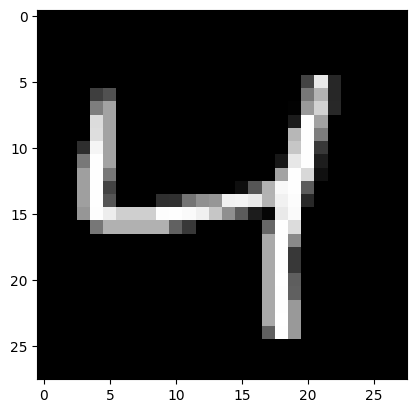

In [13]:
image = torch.Tensor.cpu(X_train[2])
plt.imshow(image.squeeze(0), cmap='gray')

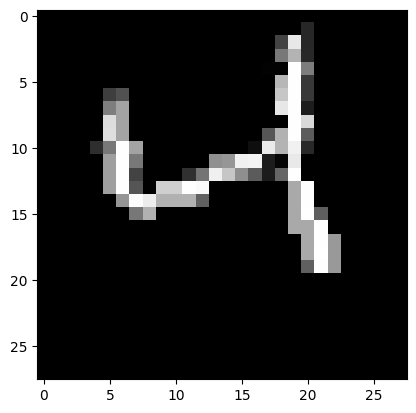

In [15]:
image = transform(torch.Tensor.cpu(X_train[2]))
plt.imshow(image.squeeze(0), cmap='gray')

# Functions

## Accuracy Measurement

In [16]:
# Function to calculate accuracy
def calculate_accuracy(y_pred, y_data):

  
  with torch.no_grad():
    correct = 0
    total = 0

    # Convert predictions to class labels
    _, predicted = torch.max(y_pred, 1)

    # Compare predictions with ground truth labels
    correct += (predicted == y_data).sum().item()  # Count correct predictions
    total += y_data.size(0)  # Count total samples

    accuracy = 100 * correct / total  # Accuracy in percentage
    return accuracy

## Loss Curve Plotter

In [17]:
def plot_loss(train_losses, validation_losses, epochs):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Create a 1x2 subplot layout

    # Convert epoch range to a NumPy array
    epochs_arr = np.array(range(1, epochs + 1))

    # Fit a polynomial (degree=3 for smoothness) to the loss data
    train_fit = np.poly1d(np.polyfit(epochs_arr, train_losses, deg=3))
    val_fit = np.poly1d(np.polyfit(epochs_arr, validation_losses, deg=3))

    # Generate smooth line points
    smooth_epochs = np.linspace(1, epochs, 100)

    # 📌 First Subplot: Training vs Validation Loss
    ax[0].plot(epochs_arr, train_losses, label='Training Loss', marker='o', color='b')
    ax[0].plot(epochs_arr, validation_losses, label='Validation Loss', marker='o', color='r')
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].set_title("Training vs Validation Loss")
    ax[0].legend()

    # 📌 Second Subplot: Training vs Validation Loss with Best Fit
    ax[1].scatter(epochs_arr, train_losses, label="Training Loss", color="b", alpha=0.5)
    ax[1].scatter(epochs_arr, validation_losses, label="Validation Loss", color="r", alpha=0.5)
    ax[1].plot(smooth_epochs, train_fit(smooth_epochs), label="Train Trend", color="b", linestyle="--")
    ax[1].plot(smooth_epochs, val_fit(smooth_epochs), label="Validation Trend", color="r", linestyle="--")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].set_title("Training vs Validation Loss with Best Fit")
    ax[1].legend()

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


## Accuracy Plotter

In [18]:
def plot_accuracy(train_accuracies, validation_accuracies, epochs):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Create a 1x2 subplot layout

    # Convert epoch range to a NumPy array
    epochs_arr = np.array(range(1, epochs + 1))

    # Fit a polynomial (degree=3 for smoothness) to the accuracy data
    train_fit = np.poly1d(np.polyfit(epochs_arr, train_accuracies, deg=3))
    val_fit = np.poly1d(np.polyfit(epochs_arr, validation_accuracies, deg=3))

    # Generate smooth line points
    smooth_epochs = np.linspace(1, epochs, 100)

    # 📌 First Subplot: Training vs Validation Accuracy
    ax[0].plot(epochs_arr, train_accuracies, label='Training Accuracy', marker='o', color='r')
    ax[0].plot(epochs_arr, validation_accuracies, label='Validation Accuracy', marker='o', color='b')
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy (%)")
    ax[0].set_title("Training vs Validation Accuracy")
    ax[0].legend()

    # 📌 Second Subplot: Training vs Validation Accuracy with Best Fit
    ax[1].scatter(epochs_arr, train_accuracies, label="Training Accuracy", color="r", alpha=0.5)
    ax[1].scatter(epochs_arr, validation_accuracies, label="Validation Accuracy", color="b", alpha=0.5)
    ax[1].plot(smooth_epochs, train_fit(smooth_epochs), label="Train Trend", color="r", linestyle="--")
    ax[1].plot(smooth_epochs, val_fit(smooth_epochs), label="Validation Trend", color="b", linestyle="--")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy (%)")
    ax[1].set_title("Training vs Validation Accuracy with Best Fit")
    ax[1].legend()

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


# CNN Model

In [16]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(

      nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=16, out_channels=10, kernel_size=3, stride=2, padding=1),
      nn.Flatten()

    )

  def forward(self,x):
    return self.model(x)


# Model Training and Validation

## 1. Training Without Batch

In [17]:
cnn = CNN().to(device)

optimiser = optim.Adam(cnn.parameters(),lr=0.005)
#optimiser = torch.optim.SGD(cnn.parameters(),lr=0.01)
loss_fn = nn.CrossEntropyLoss()
#scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=10, gamma=0.1)

epochs = 350
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []


for epoch in tqdm(range(epochs)):

  # randomly transform the images
  X_train_transform = transform(X_train).to(device)

  # Training Step
  cnn.train()  # Set to training mode
  y_train_pred = cnn(X_train_transform)

  # Calculate training loss and training accuracy
  loss = loss_fn(y_train_pred, y_train)
  train_losses.append(loss.item())
  train_accuracy = calculate_accuracy(y_train_pred, y_train)
  train_accuracies.append(train_accuracy)
  # print(f"Epoch: {epoch} Training Loss: {loss.item():.6f} Accuracy: {train_accuracy:.2f}%")

  optimiser.zero_grad()
  loss.backward()
  optimiser.step()

  # Validation Step
  cnn.eval()  # Set to evaluation mode
  with torch.no_grad():
    X_test_transform = transform(X_test).to(device)
    y_test_pred = cnn(X_test_transform)

    # Calculate validation loss and validation accuracy
    val_loss = loss_fn(y_test_pred, y_test)
    validation_losses.append(val_loss.item())
    validation_accuracy = calculate_accuracy(y_test_pred, y_test)
    validation_accuracies.append(validation_accuracy)
    # print(f"Epoch: {epoch} Validation Loss: {val_loss.item():.6f} Accuracy: {validation_accuracy:.2f}%")


100%|██████████| 350/350 [08:31<00:00,  1.46s/it]


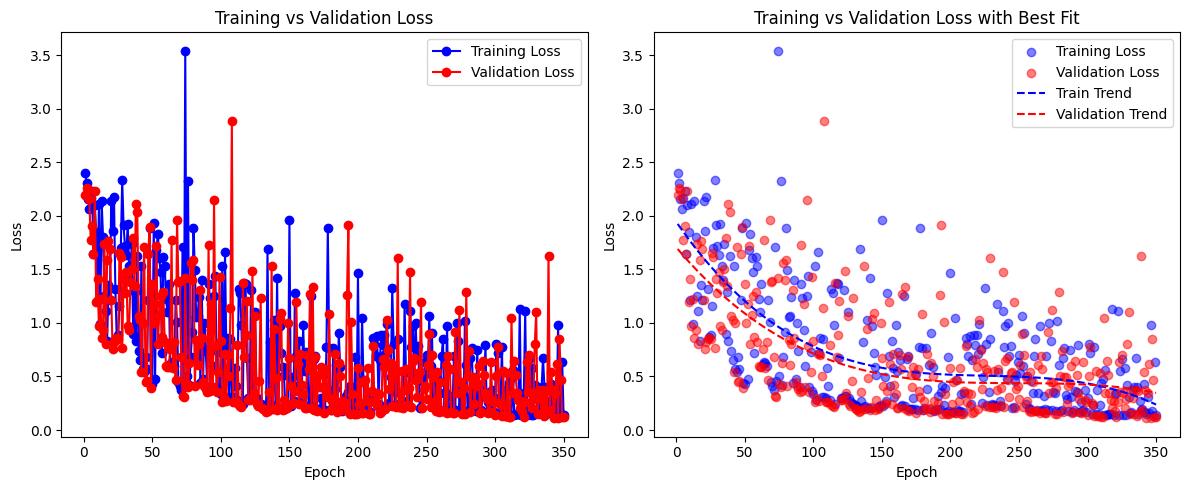

In [18]:
plot_loss(train_losses,validation_losses,epochs)

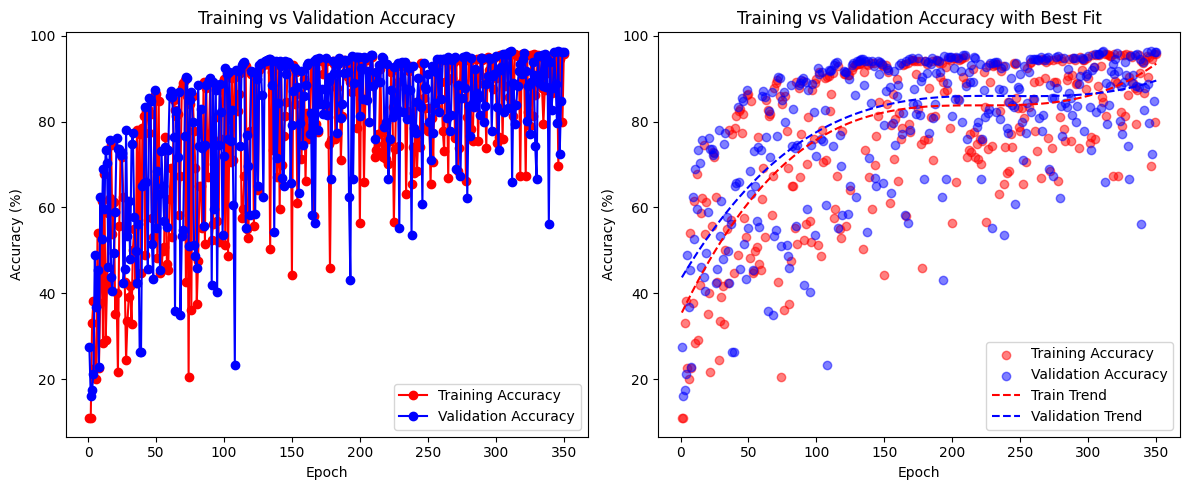

In [19]:
plot_accuracy(train_accuracies,validation_accuracies,epochs)

## 2. Batch Training

In [20]:
cnn = CNN().to(device)
optimizer = optim.Adam(cnn.parameters(), lr=0.005)
loss_fn = nn.CrossEntropyLoss()


epochs = 10
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in tqdm(range(epochs)):
    # Training Phase
    cnn.train()
    total_train_loss = 0
    train_accuracy = 0

    for images, labels in train_loader:
        images, labels = transform(images).to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = cnn(images)  
        loss = loss_fn(outputs, labels)
        total_train_loss += loss.item()
        train_accuracy += calculate_accuracy(outputs, labels)
        
        loss.backward()
        optimizer.step() 

    train_losses.append(total_train_loss / len(train_loader))
    train_accuracies.append(train_accuracy / len(train_loader))

    
    # Validation Phase
    total_val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = transform(images).to(device), labels.to(device)
            outputs = cnn(images)
            val_loss = loss_fn(outputs, labels)
            total_val_loss += val_loss.item()
            val_accuracy += calculate_accuracy(outputs, labels)

    validation_losses.append(total_val_loss / len(test_loader))
    validation_accuracies.append(val_accuracy / len(test_loader))

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.2f}% | "
          f"Val Loss: {validation_losses[-1]:.4f} | Val Acc: {validation_accuracies[-1]:.2f}%")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 | Train Loss: 0.5641 | Train Acc: 82.15% | Val Loss: 0.3904 | Val Acc: 87.58%


 10%|█         | 1/10 [00:39<05:59, 39.98s/it]

Epoch 2/10 | Train Loss: 0.3873 | Train Acc: 88.22% | Val Loss: 0.3576 | Val Acc: 88.86%


 20%|██        | 2/10 [01:20<05:20, 40.03s/it]

Epoch 3/10 | Train Loss: 0.3536 | Train Acc: 89.11% | Val Loss: 0.3414 | Val Acc: 90.52%


 30%|███       | 3/10 [02:00<04:40, 40.07s/it]

Epoch 4/10 | Train Loss: 0.3415 | Train Acc: 89.66% | Val Loss: 0.3299 | Val Acc: 90.55%


 40%|████      | 4/10 [02:40<04:01, 40.18s/it]

Epoch 5/10 | Train Loss: 0.3423 | Train Acc: 89.66% | Val Loss: 0.3042 | Val Acc: 90.57%


 50%|█████     | 5/10 [03:20<03:20, 40.11s/it]

Epoch 6/10 | Train Loss: 0.3187 | Train Acc: 90.15% | Val Loss: 0.2874 | Val Acc: 91.56%


 60%|██████    | 6/10 [04:00<02:40, 40.11s/it]

Epoch 7/10 | Train Loss: 0.3284 | Train Acc: 90.07% | Val Loss: 0.4483 | Val Acc: 88.14%


 70%|███████   | 7/10 [04:40<02:00, 40.12s/it]

Epoch 8/10 | Train Loss: 0.3014 | Train Acc: 90.81% | Val Loss: 0.2727 | Val Acc: 91.51%


 80%|████████  | 8/10 [05:20<01:20, 40.03s/it]

Epoch 9/10 | Train Loss: 0.3027 | Train Acc: 90.81% | Val Loss: 0.3038 | Val Acc: 91.42%


 90%|█████████ | 9/10 [06:00<00:40, 40.14s/it]

Epoch 10/10 | Train Loss: 0.3003 | Train Acc: 90.90% | Val Loss: 0.3484 | Val Acc: 88.89%


100%|██████████| 10/10 [06:41<00:00, 40.12s/it]


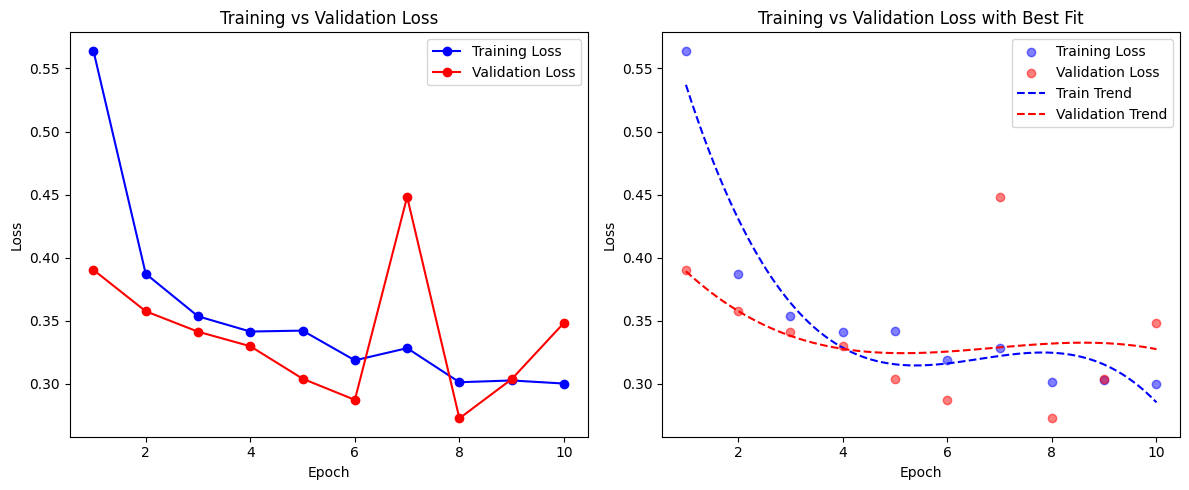

In [21]:
plot_loss(train_losses,validation_losses,epochs)

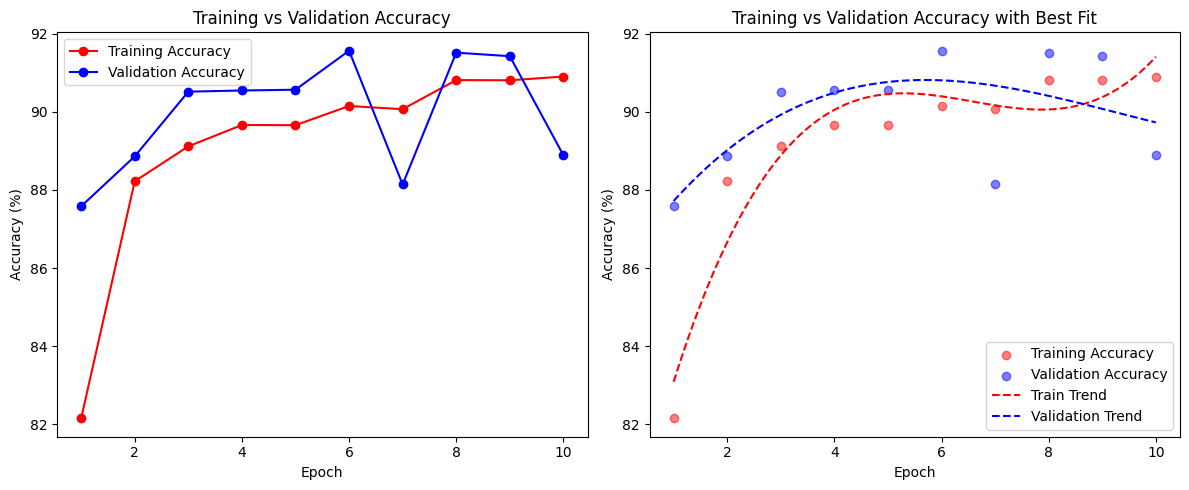

In [22]:
plot_accuracy(train_accuracies,validation_accuracies,epochs)

# Residual Neural Network

In [22]:
# Define a Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride = 1, downsample = False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        if downsample:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False), 
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.residual = nn.Identity()  # No downsampling, keep identity connection

    def forward(self, x):
        residual = self.residual(x)  # Ensure this matches the shape of conv path

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x += residual  # Now both tensors have the same size
        return F.relu(x)

In [27]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.initial_conv = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1, bias=False),  # (28x28) → (28x28)
            nn.BatchNorm2d(8),
            nn.ReLU()
        )

        self.res_block1 = ResidualBlock(8, 8)  # (8x28x28) → (8x28x28)
        self.res_block2 = ResidualBlock(8, 16, stride=2, downsample=True)  # (8x28x28) → (16x14x14)
        self.res_block3 = ResidualBlock(16, 32, stride=2, downsample=True)  # (16x14x14) → (32x7x7)
        self.res_block4 = ResidualBlock(32, 64, stride=2, downsample=True)  # (32x7x7) → (64x4x4)
        self.res_block5 = ResidualBlock(64, 128, stride=2, downsample=True)  # (64x4x4) → (128x2x2)
        self.res_block6 = ResidualBlock(128, 256, stride=2, downsample=True)  # (128x2x2) → (256x1x1)

        self.flatten = nn.Flatten()  # (256, 1, 1) -> (256)

        # Fully connected layers
        self.fc = nn.Linear(256, num_classes)   # 256 -> 10
        self.bn = nn.BatchNorm1d(num_classes)   # batch norm over final output (10) -> (10)

    def forward(self, x):
        x = self.initial_conv(x)    # (8x28x28) → (8x28x28)
        x = self.res_block1(x)      # (8x28x28) → (8x28x28)
        x = self.res_block2(x)      # (8x28x28) → (16x14x14)
        x = self.res_block3(x)      # (16x14x14) → (32x7x7)
        x = self.res_block4(x)      # (32x7x7) → (64x4x4)     
        x = self.res_block5(x)      # (64x4x4) → (128x2x2)
        x = self.res_block6(x)      # (128x2x2) → (256x1x1)
        x = self.flatten(x)         # (256x1x1) → (256)
        x = self.fc(x)              # (256) → (256) Fully Connected Layer
        x = self.bn(x)              # (256) → (1)   BatchNorm for final output
        return x


In [28]:
resnet = ResNet().to(device)
optimizer = optim.Adam(resnet.parameters(), lr=0.005)
loss_fn = nn.CrossEntropyLoss()


epochs = 10
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in tqdm(range(epochs)):
    # Training Phase
    resnet.train()
    total_train_loss = 0
    train_accuracy = 0

    for images, labels in train_loader:
        images, labels = transform(images).to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(images)  
        loss = loss_fn(outputs, labels)
        total_train_loss += loss.item()
        train_accuracy += calculate_accuracy(outputs, labels)
        
        loss.backward()
        optimizer.step() 

    train_losses.append(total_train_loss / len(train_loader))
    train_accuracies.append(train_accuracy / len(train_loader))

    
    # Validation Phase
    total_val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = transform(images).to(device), labels.to(device)
            outputs = resnet(images)
            val_loss = loss_fn(outputs, labels)
            total_val_loss += val_loss.item()
            val_accuracy += calculate_accuracy(outputs, labels)

    validation_losses.append(total_val_loss / len(test_loader))
    validation_accuracies.append(val_accuracy / len(test_loader))
    
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.2f}% | "
          f"Validation Loss: {validation_losses[-1]:.4f} | Train Acc: {validation_accuracies[-1]:.2f}% | ")
    

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 | Train Loss: 0.3578 | Train Acc: 90.34% | Validation Loss: 0.1429 | Train Acc: 96.21% | 


 10%|█         | 1/10 [01:23<12:31, 83.49s/it]

Epoch 2/10 | Train Loss: 0.1559 | Train Acc: 95.64% | Validation Loss: 0.0968 | Train Acc: 97.37% | 


 20%|██        | 2/10 [02:46<11:07, 83.44s/it]

Epoch 3/10 | Train Loss: 0.1220 | Train Acc: 96.53% | Validation Loss: 0.0877 | Train Acc: 97.47% | 


 30%|███       | 3/10 [04:09<09:42, 83.16s/it]

Epoch 4/10 | Train Loss: 0.0999 | Train Acc: 97.19% | Validation Loss: 0.0747 | Train Acc: 97.95% | 


 40%|████      | 4/10 [05:33<08:20, 83.43s/it]

Epoch 5/10 | Train Loss: 0.0874 | Train Acc: 97.42% | Validation Loss: 0.0733 | Train Acc: 97.88% | 


 50%|█████     | 5/10 [06:57<06:57, 83.58s/it]

Epoch 6/10 | Train Loss: 0.0723 | Train Acc: 97.86% | Validation Loss: 0.0721 | Train Acc: 97.84% | 


 60%|██████    | 6/10 [08:21<05:34, 83.60s/it]

Epoch 7/10 | Train Loss: 0.0723 | Train Acc: 97.95% | Validation Loss: 0.0513 | Train Acc: 98.51% | 


 70%|███████   | 7/10 [09:44<04:11, 83.68s/it]

Epoch 8/10 | Train Loss: 0.0636 | Train Acc: 98.08% | Validation Loss: 0.0566 | Train Acc: 98.32% | 


 80%|████████  | 8/10 [11:08<02:47, 83.52s/it]

Epoch 9/10 | Train Loss: 0.0595 | Train Acc: 98.19% | Validation Loss: 0.0466 | Train Acc: 98.50% | 


 90%|█████████ | 9/10 [12:31<01:23, 83.54s/it]

Epoch 10/10 | Train Loss: 0.0543 | Train Acc: 98.41% | Validation Loss: 0.0533 | Train Acc: 98.49% | 


100%|██████████| 10/10 [13:55<00:00, 83.51s/it]


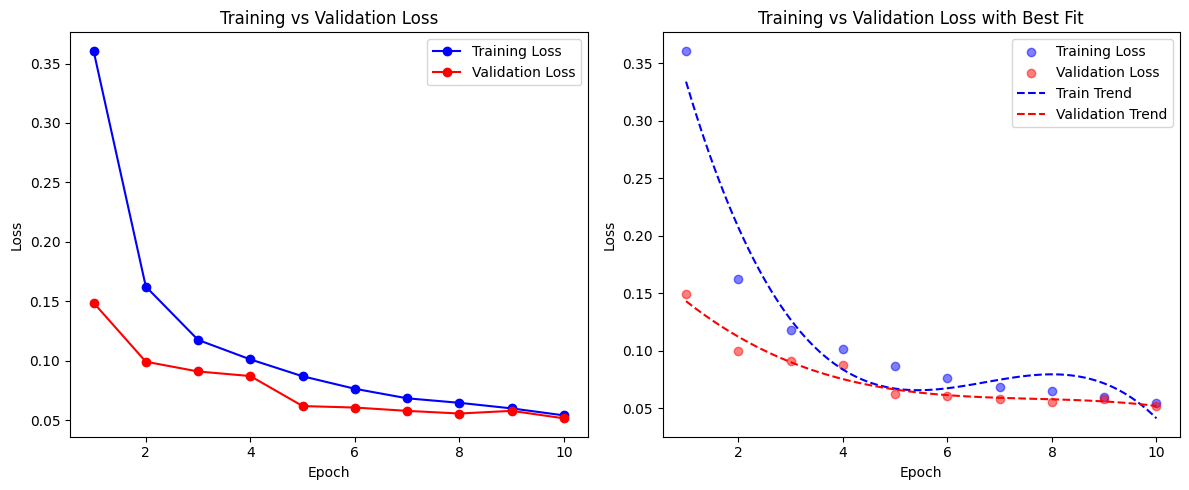

In [20]:
plot_loss(train_losses,validation_losses,epochs)

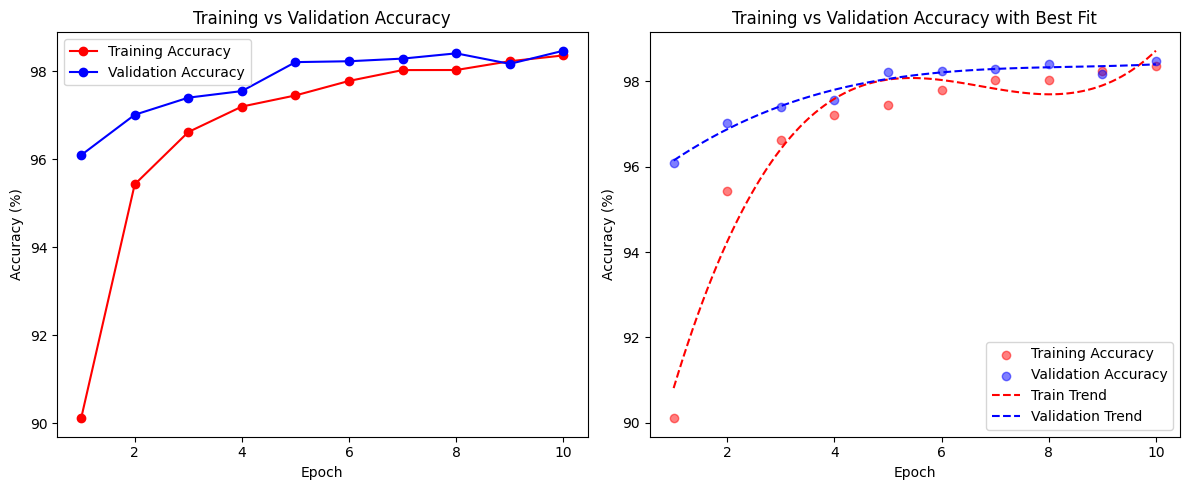

In [21]:
plot_accuracy(train_accuracies,validation_accuracies,epochs)

Initial:

nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),  # (28x28) → (8x28x28)
nn.BatchNorm2d(8), # (8x28x28) → (8x28x28)
nn.ReLU() # (8x28x28) → (8x28x28)



Block 1: ResidualBlock(8, 8):

Residual (No Downsampling): # (8x28x28) 

Features:
nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1) # (8x28x28) → (8x28x28)
nn.BatchNorm2d(8)
nn.ReLU()
nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1) # (8x28x28) → (8x28x28)
nn.BatchNorm2d(8)

After Addition: (8x28x28) 


Block 2: ResidualBlock(8, 16, stride=2, downsample=True):

Residual (Downsampling): # Apply 1 x 1 Convolution
nn.Conv2d(8, 16, kernel_size=1, stride=2) # 16 x 14 x 14
nn.BatchNorm2d(16)

Features:
nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1) # (8x28x28) → (16x14x14)
nn.BatchNorm2d(16)
nn.ReLU()
nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1) # (16x14x14) → (16x14x14)
nn.BatchNorm2d(16)

After Addition: (16x14x14) 





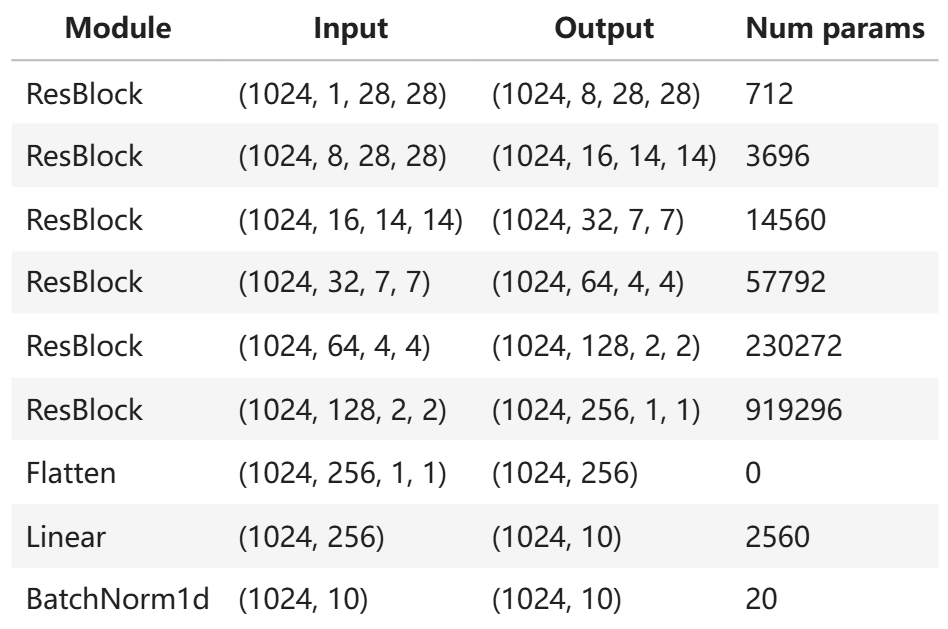